In [26]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from torchvision.io import read_image

from src.detections_generation import import_from_hdf5
from src.features_generation import H5_FILE, FRAME_FOLDER

# Visualize and extraction of bboxes on a single frame

To compute image features from bboxes, we would like to extract bboxes area from frame. 

Although, I am not sure about the bound of bboxes coordinates and the frame dimension.

So in this notebook, we will take one detection result from H5 file and we will plot them. Also, we will test the code to extract the region of interest.

In [60]:
frame_to_detection = list(import_from_hdf5(H5_FILE, FRAME_FOLDER).items())


In [69]:
frame, detection = frame_to_detection[4]

In [70]:
frame, detection.scores.shape, detection.bboxes.shape

(PosixPath('/home/reusm/data/frames/s10019.jpg'),
 torch.Size([100]),
 torch.Size([100, 4]))

In [71]:
frame_tensor = read_image(str(frame))
frame_tensor.shape

torch.Size([3, 800, 600])

Check if every bboxes fits in frame shape

In [72]:
detection.bboxes[0]

tensor([149.9611, 144.6688, 463.2517, 560.5876])

In [65]:
all(
    all( 
        coord <= frame_tensor.shape[2]
        if i % 2
        else coord <= frame_tensor.shape[1]
        for coord,i in enumerate(bbox)
    )
    for bbox in detection.bboxes
)

True

In [73]:
bboxes = [
    frame_tensor[:,int(bbox[0]):int(bbox[2]), int(bbox[1]):int(bbox[3])]
    for bbox in detection.bboxes
]

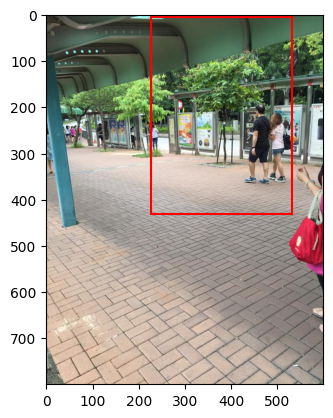

In [88]:
def plot_bbox(frame_to_detection, i, threshold):
    frame, detection = frame_to_detection[i]

    plt.figure()
    plt.imshow(plt.imread(str(frame)))
    for bbox, score in zip(detection.bboxes, detection.scores):
        if score >= threshold:
            plt.gca().add_patch(Rectangle(
                (bbox[0], bbox[1]), 
                bbox[2] - bbox[0], 
                bbox[3] - bbox[1],
                edgecolor='red',
                facecolor='none',
                lw=1.5
            ))
    plt.show()
plot_bbox(frame_to_detection, 13, .77)

For any value of `i`, so any frame, it seems that the bboxes are too big!